In [1]:
import os.path as osp
import json
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
%matplotlib inline

from reid import datasets, models
from reid.utils.data import transforms as T
from reid.utils.data.preprocessor import Preprocessor
from reid.utils.osutils import set_paths
from reid.utils.serialization import load_checkpoint
from reid.models.CompactBilinearPooling_dsybaik import CompactBilinearPooling

import torch
from torch.utils.data import DataLoader

In [2]:
def flatten(maps):
    flattened = np.transpose(maps, (1, 0, 2, 3)).reshape(maps.shape[1], int(maps.size/maps.shape[1]))
    return flattened

def organize(flattened, num_map, feat_dim, h, w):
    maps = flattened.reshape(feat_dim, num_map, h, w)
    maps = np.transpose(maps, (1,0,2,3))
    return maps

def feat_to_color(maps):
    num_img, dim_feat, h, w = maps.shape
    maps_flatten = flatten(maps)
    maps_flatten_reduced = PCA(n_components=3).fit_transform(maps_flatten.transpose())
    maps_reduced = organize(maps_flatten_reduced.transpose(), num_img, 3, h, w)
    return maps_reduced

def normalize_01(m):
    max_value = m.max()
    min_value = m.min()
    r = max_value - min_value
    n = (m- min_value) / r 
    return n

def mapwise_normalize(map1, feats):
    num_sample, num_channel, h, w = map1.shape
#     norms = np.linalg.norm(np.sqrt(np.sum(map1**2, axis=(2,3))), axis=1)
    norms = np.sqrt(np.linalg.norm(feats, axis=1))
    normalized = map1 / np.reshape(norms, (num_sample, 1,1,1))
    return normalized
        
def visualize_pca_multi(maps_all, feats, num_vis=100, save_id=""):
    maps_all_reduced = []
    for maps in maps_all[1:]:
        maps_all_reduced.append(feat_to_color(mapwise_normalize(maps, feats)))
    num_person = maps_all_reduced[0].shape[0]
        
    for person_idx in range(min(num_person, num_vis)):
        fig, ax = plt.subplots(1, len(maps_all))
#         fig.set_size_inches((10,10))
        for idx, maps_reduced in enumerate([maps_all[0]] + maps_all_reduced):
            ax[idx].imshow(normalize_01(np.transpose(maps_reduced[person_idx,::-1,:,:], (1,2,0))))
            ax[idx].set_axis_off()
        plt.show()
#         fig.savefig(savepath.format(save_id, person_idx))

def sel_random_target(target):
    labels = np.unique([t[1] for t in target])
    labels = np.delete(labels, labels==0)
    sel_labels = np.random.choice(labels, 200, replace=False)
    sel_target = [t for t in target if t[1] in sel_labels]
    _, sel_target = map(list, zip(*sorted(zip([t[1] for t in sel_target], sel_target))))
    return sel_target

Set os.envirionments from paths...
----------------------------------
INCEPTION_V1_PRETRAINED pretrained/bvlc_googlenet.caffemodel.pth
CPM_PRETRAINED pretrained/pose_iter_440000.caffemodel.pth
MARKET1501_DATA_ROOT $(pwd)/data/market1501/raw/Market-1501-v15.09.15
DUKEMTMC_DATA_ROOT $(pwd)/data/dukemtmc/raw/DukeMTMC-reID
----------------------------------
done!
Files already downloaded and verified
Market1501 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   651 |    11111
  val      |   100 |     1825
  trainval |   751 |    12936
  query    |   750 |     3368
  gallery  |   751 |    15913


/home/yumin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


=> Loaded checkpoint 'logs/market1501/d2_b250/epoch_750.pth.tar'


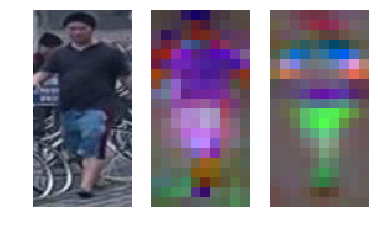

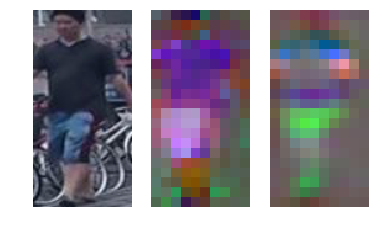

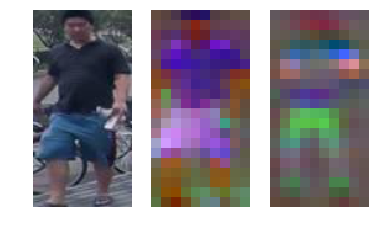

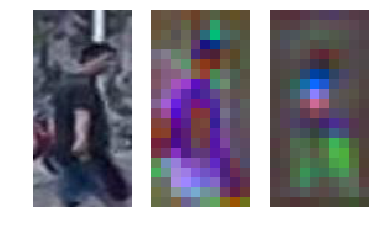

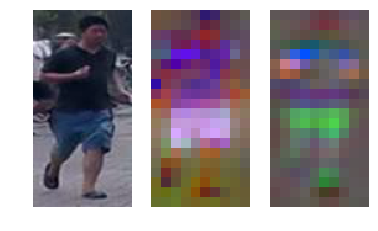

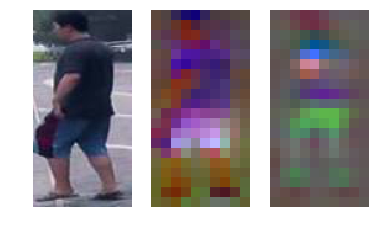

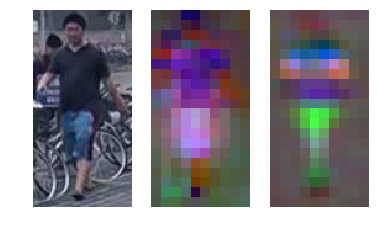

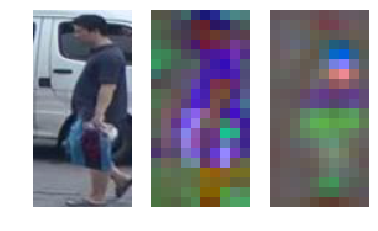

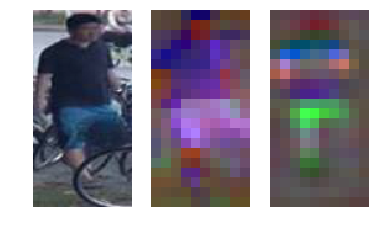

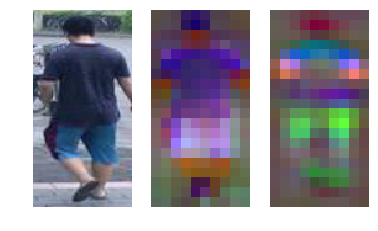

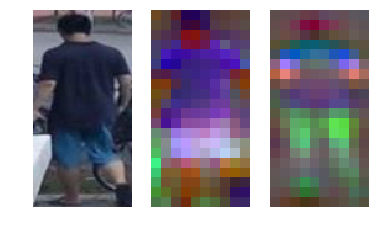

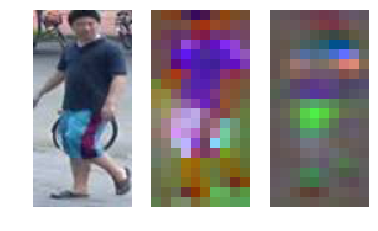

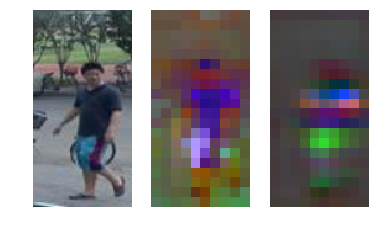

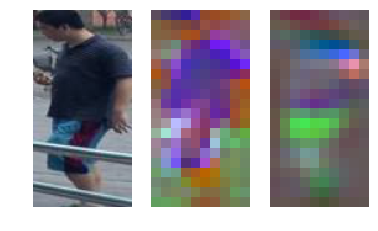

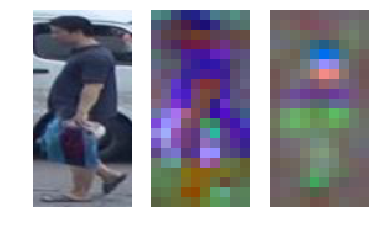

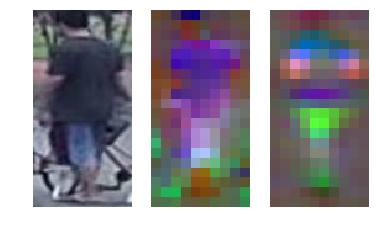

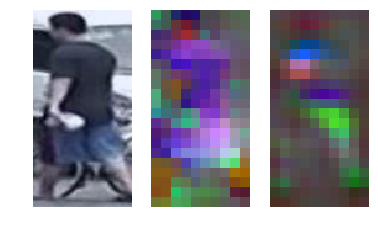

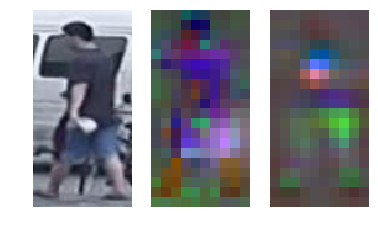

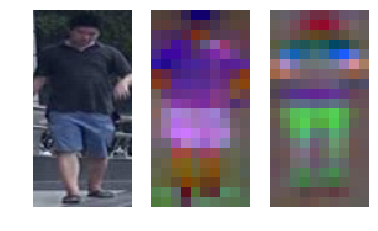

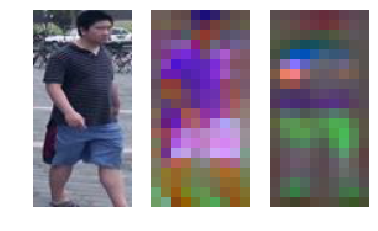

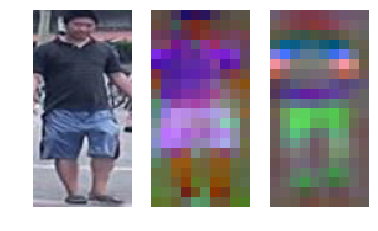

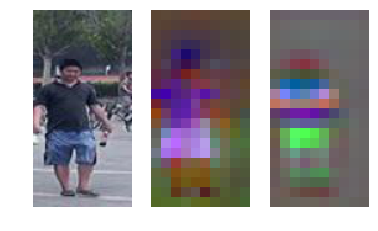

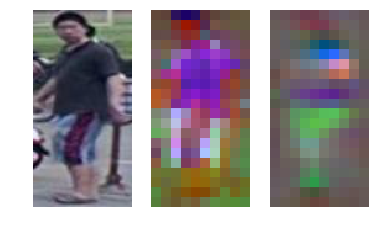

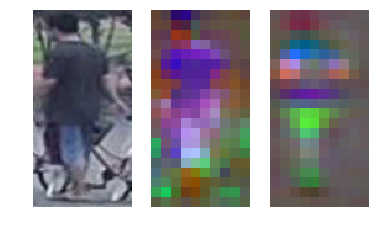

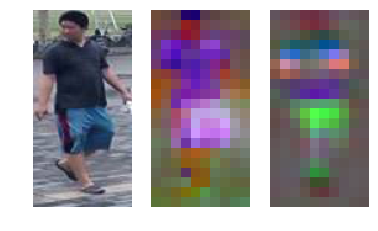

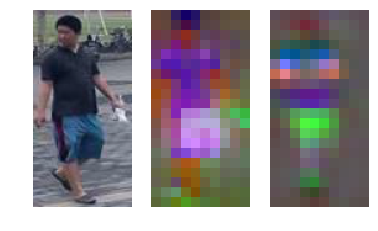

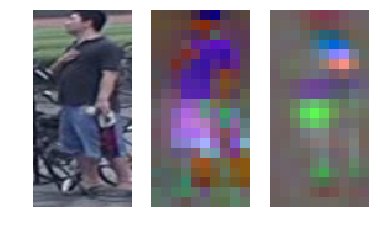

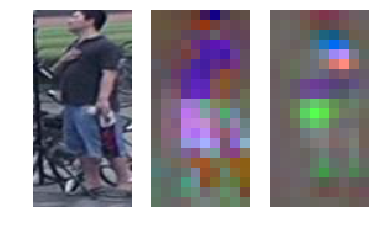

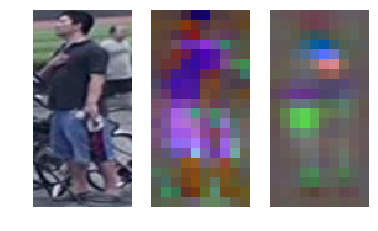

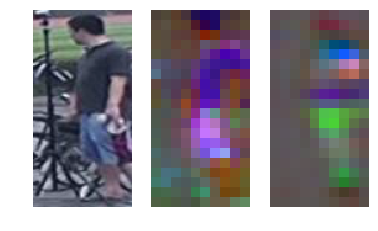

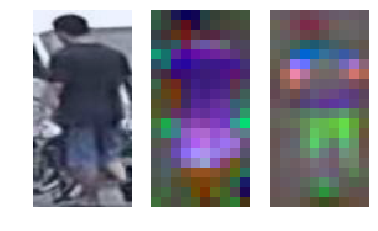

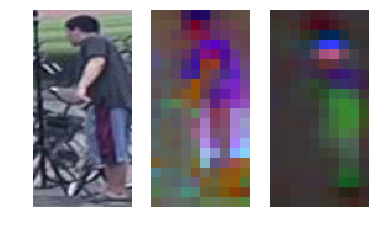

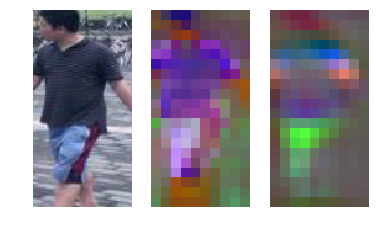

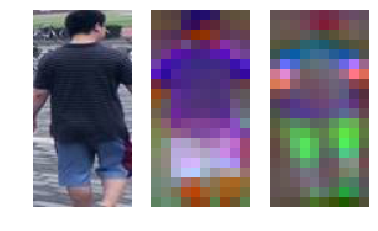

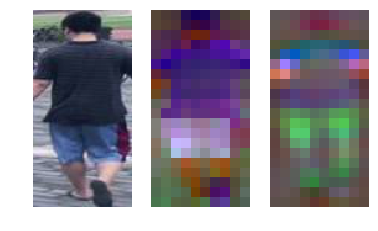

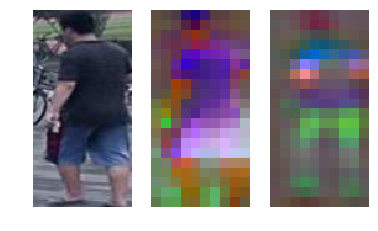

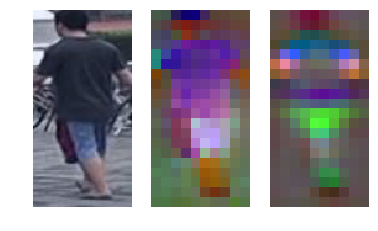

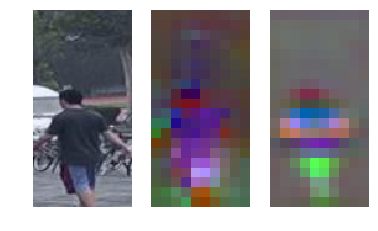

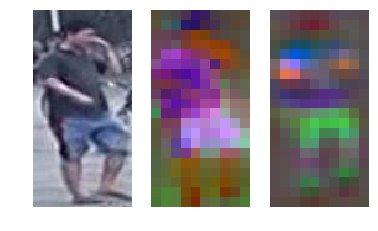

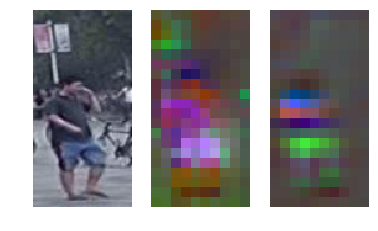

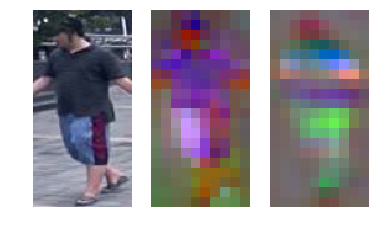

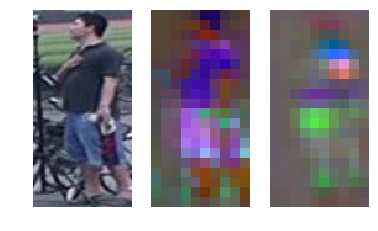

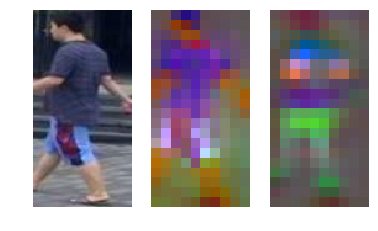

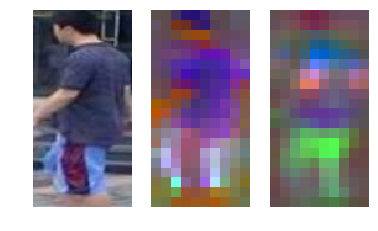

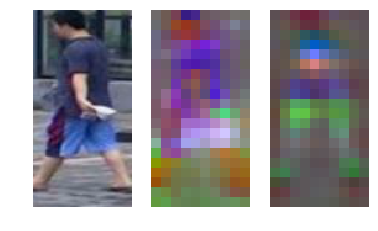

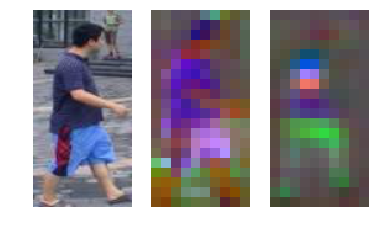

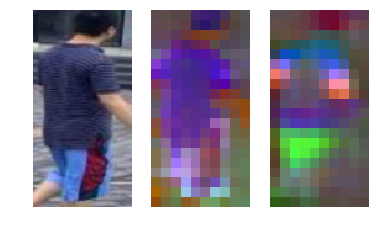

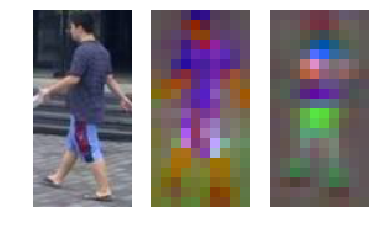

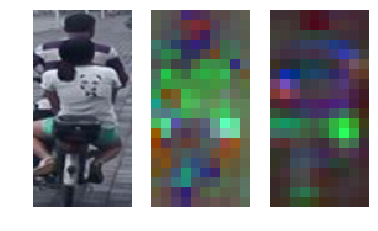

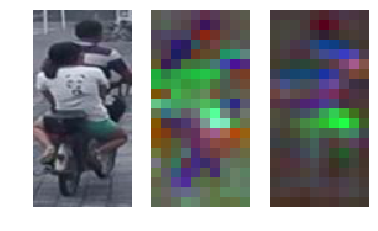

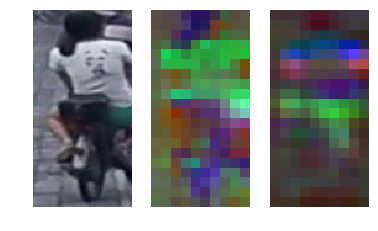

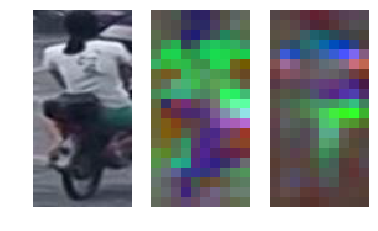

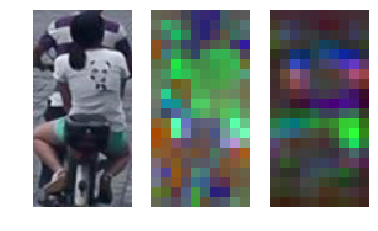

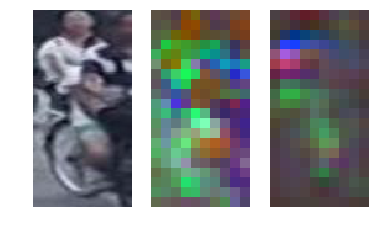

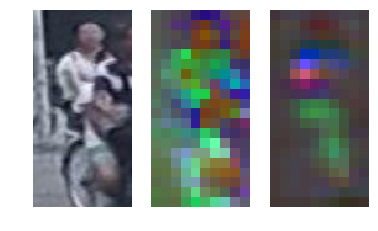

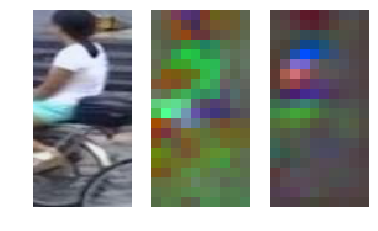

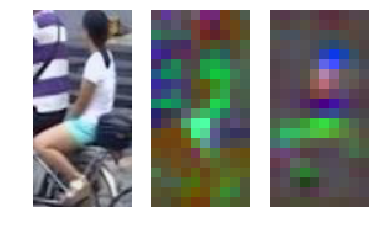

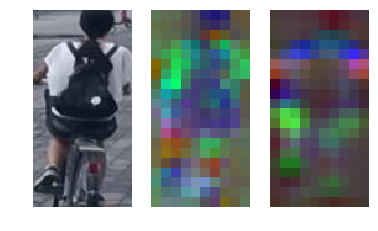

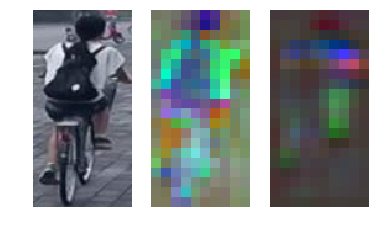

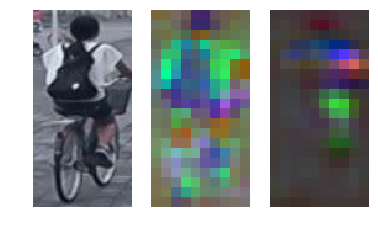

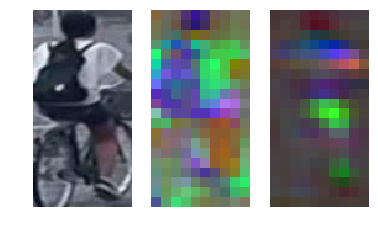

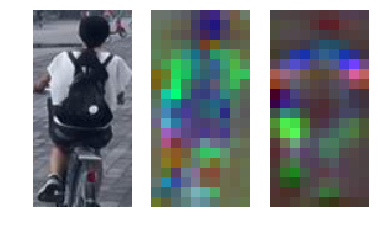

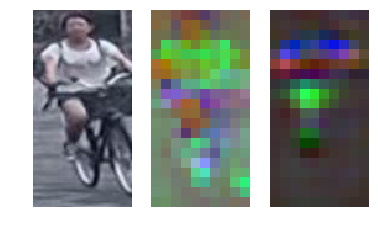

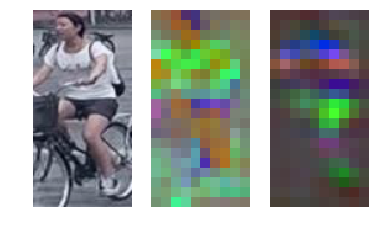

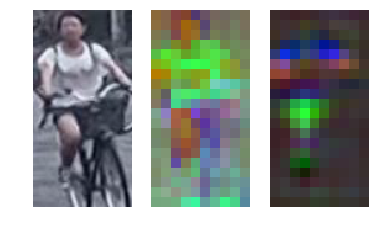

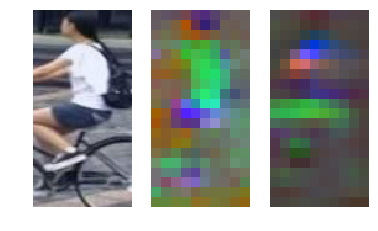

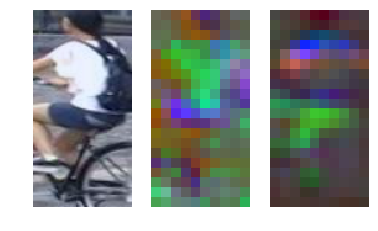

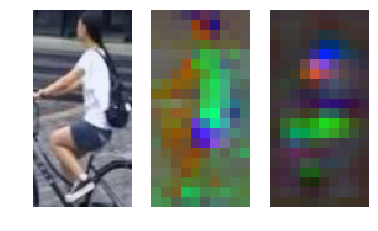

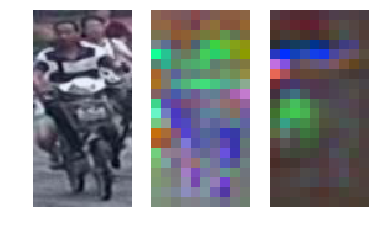

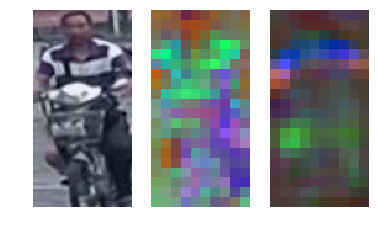

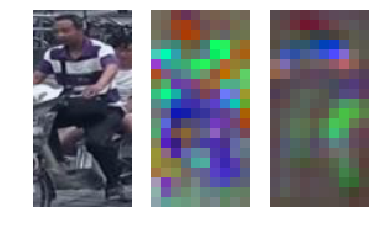

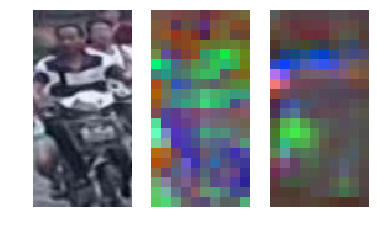

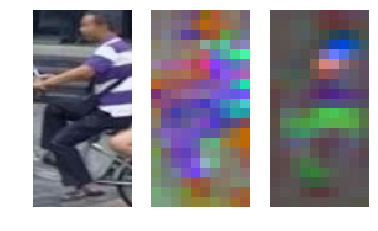

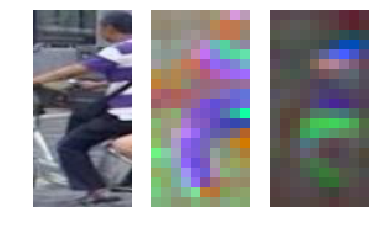

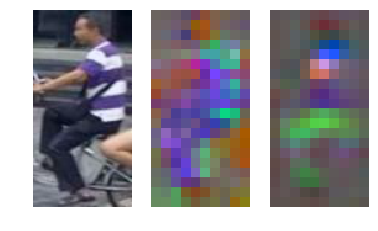

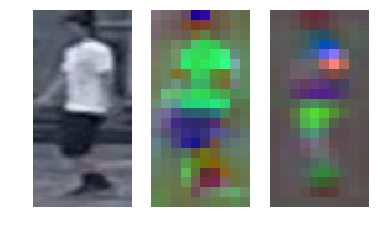

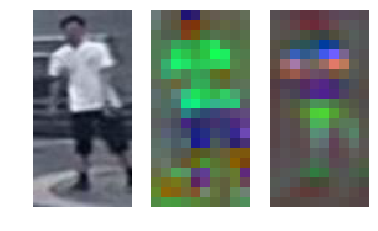

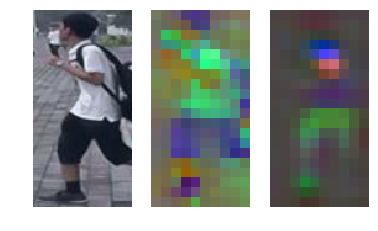

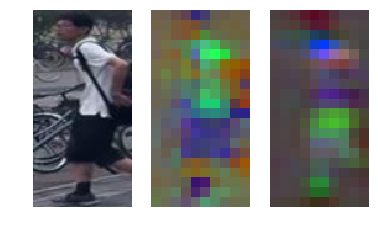

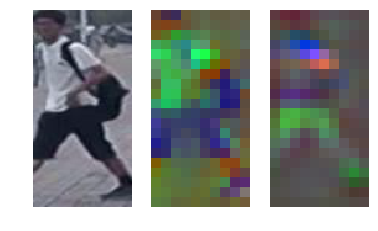

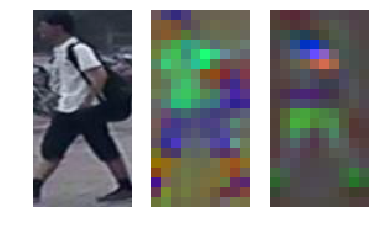

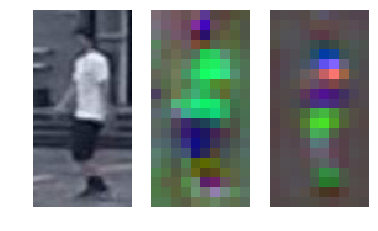

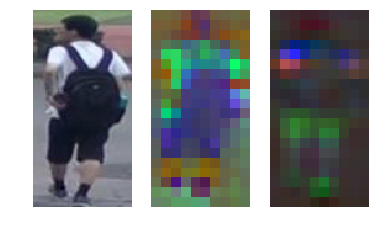

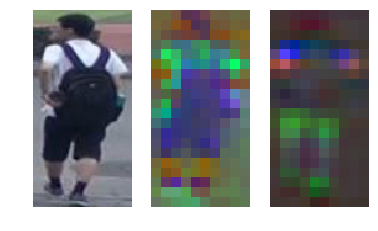

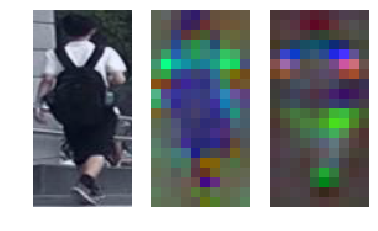

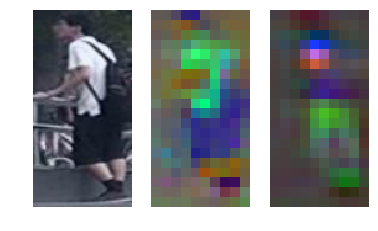

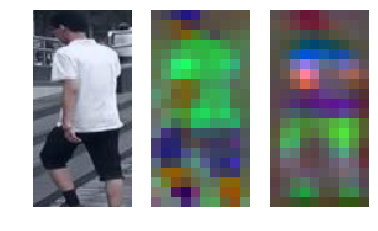

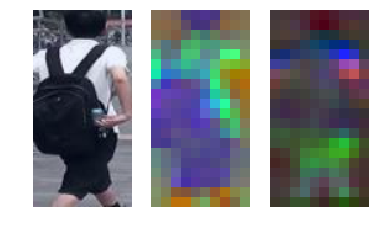

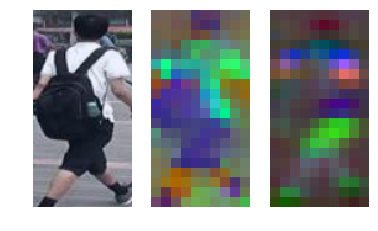

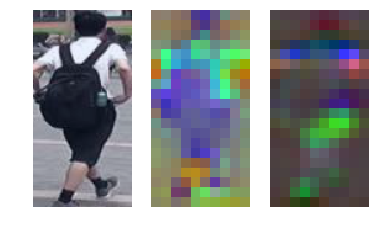

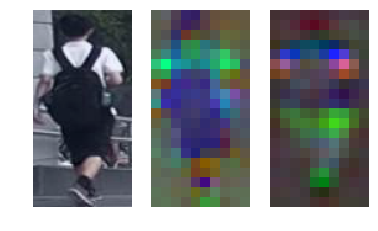

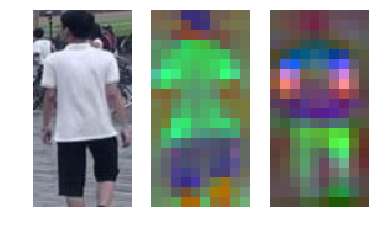

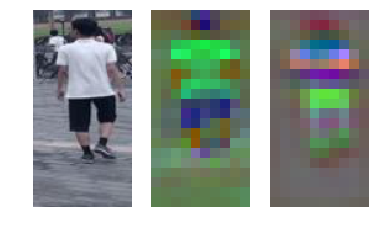

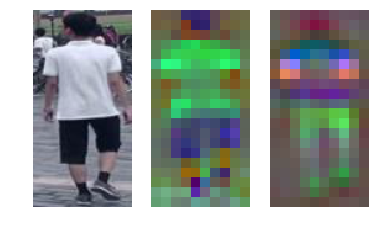

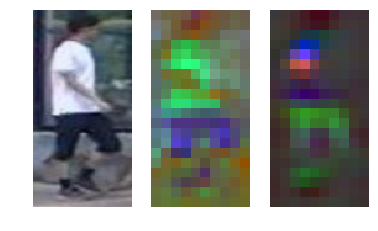

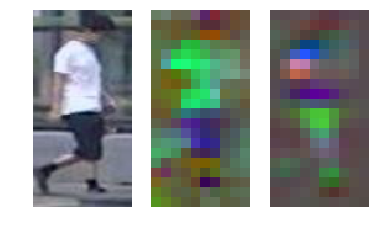

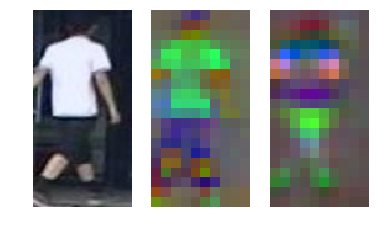

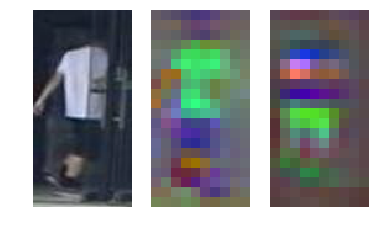

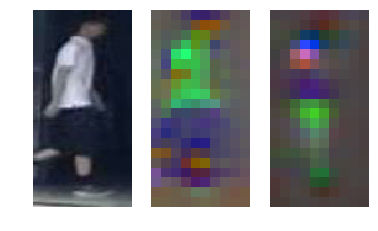

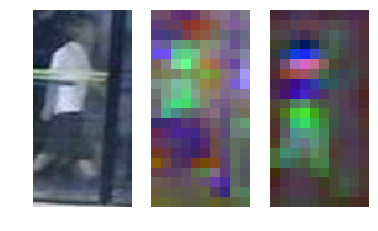

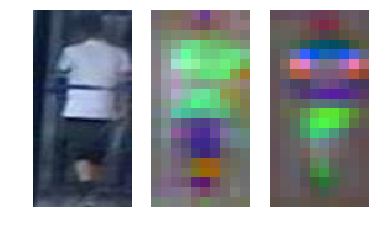

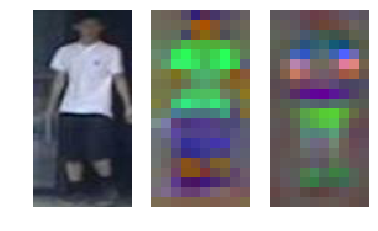

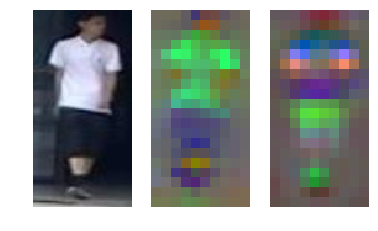

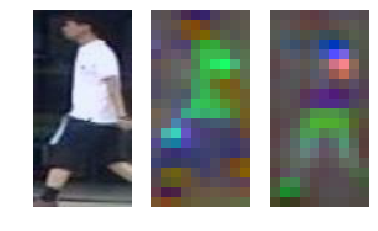

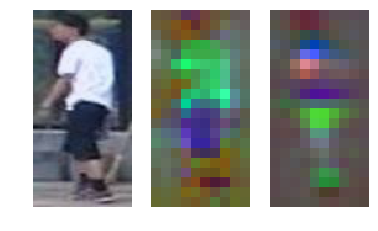

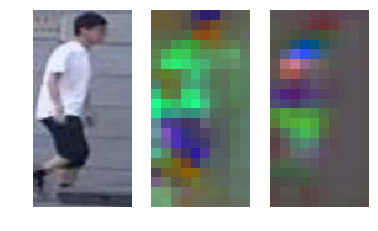

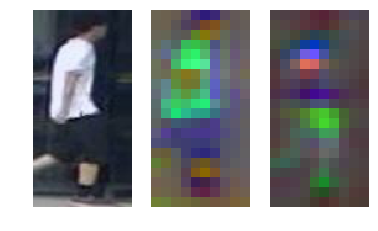

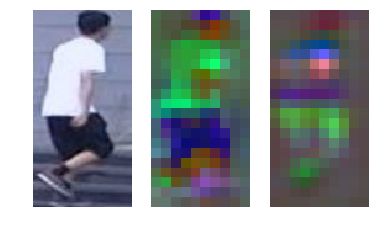

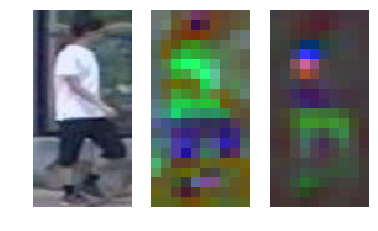

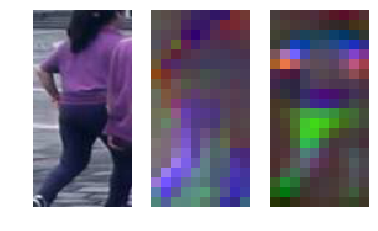

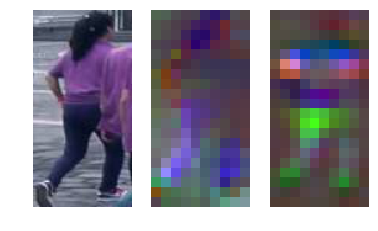

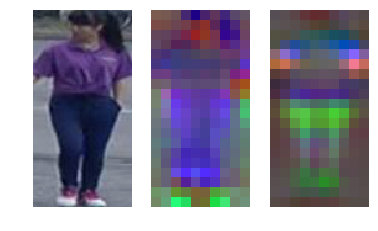

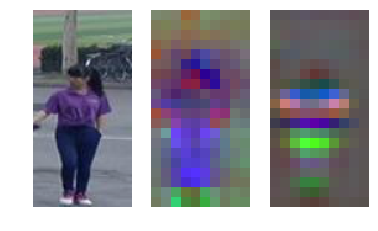

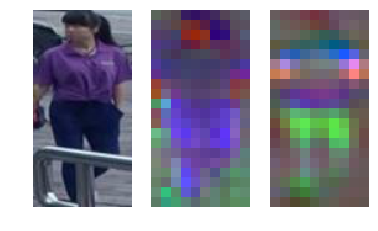

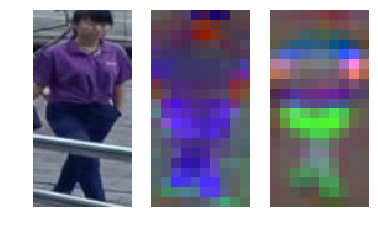

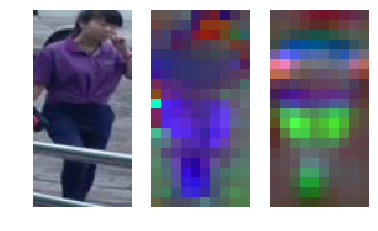

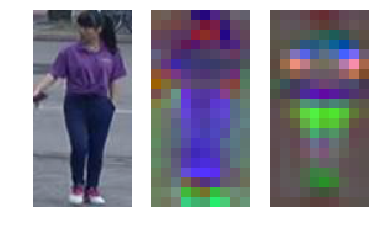

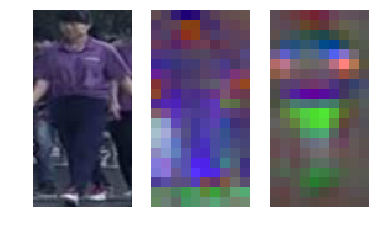

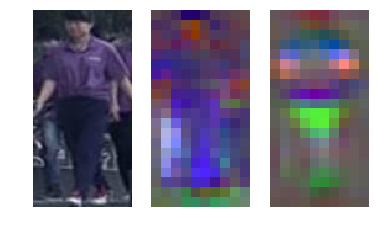

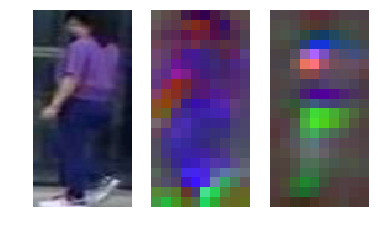

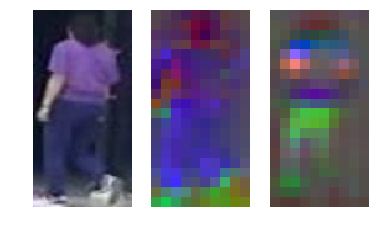

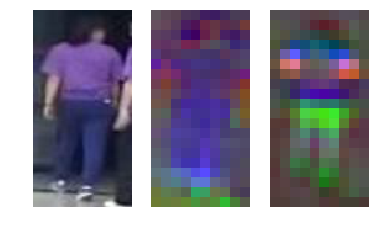

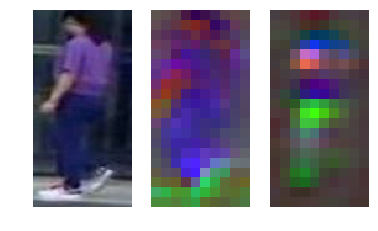

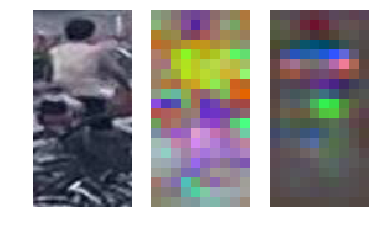

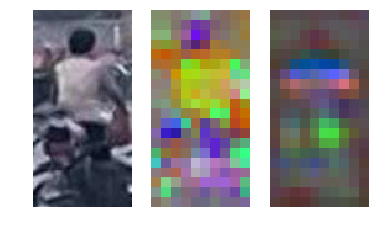

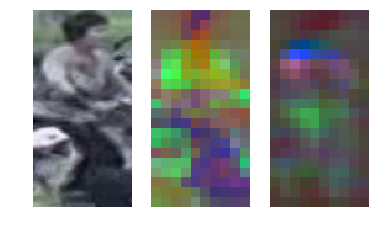

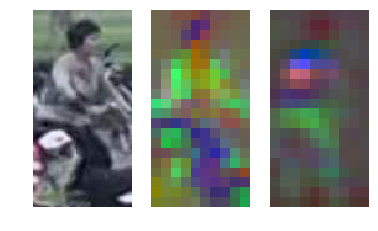

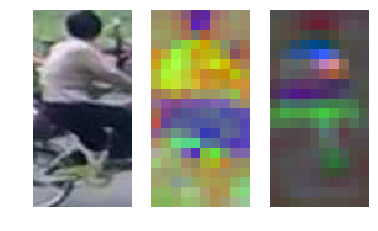

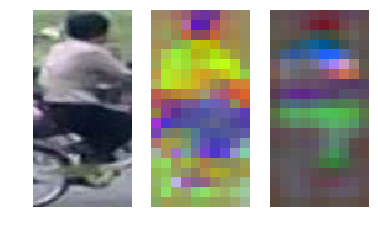

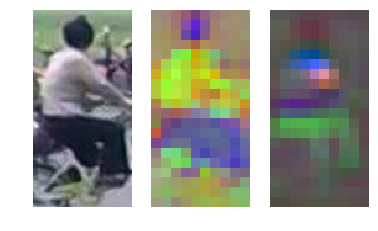

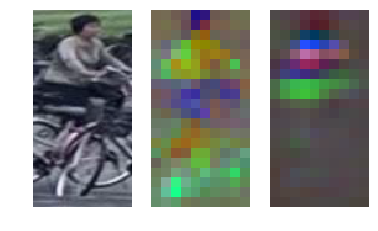

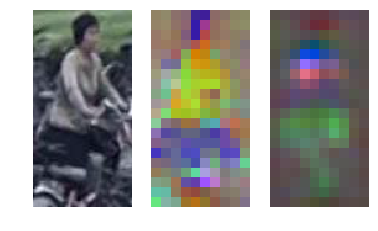

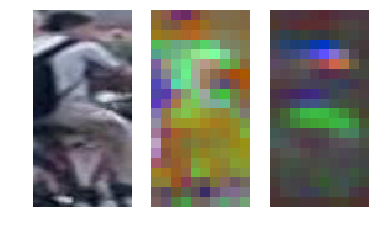

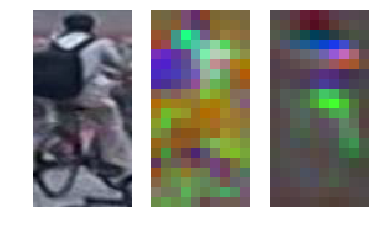

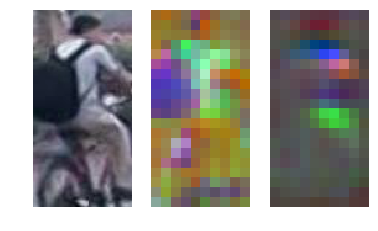

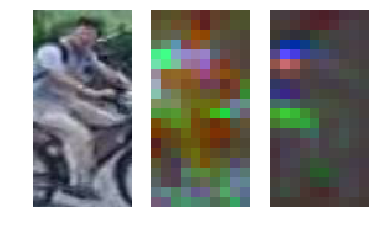

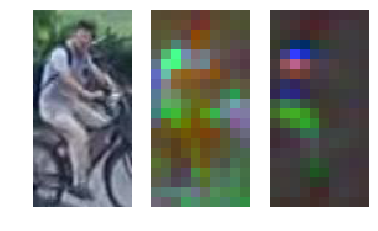

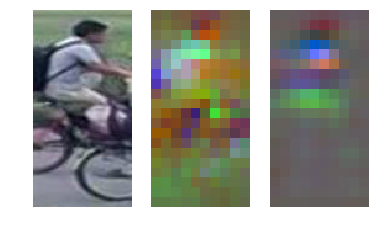

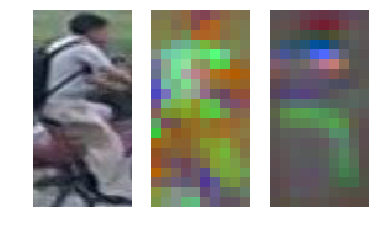

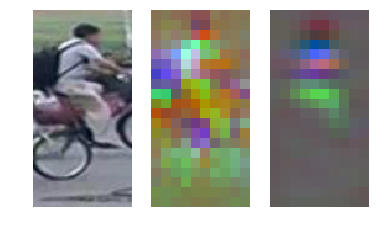

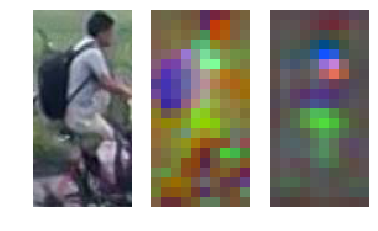

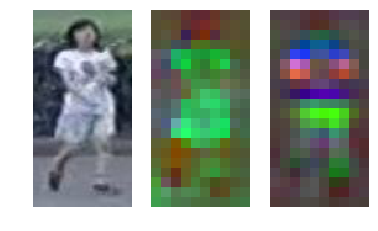

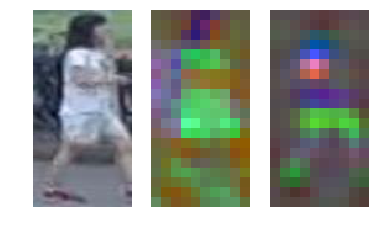

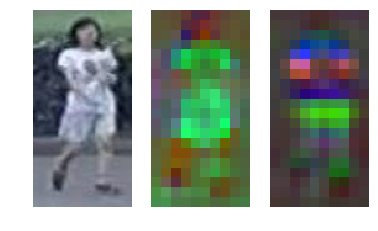

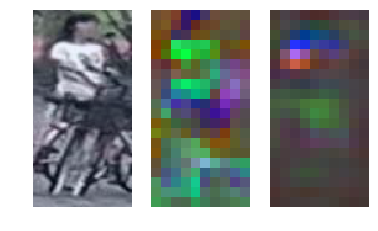

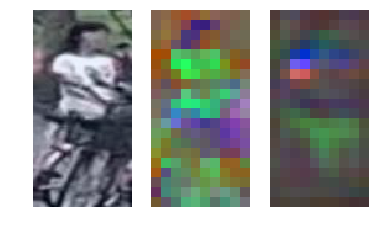

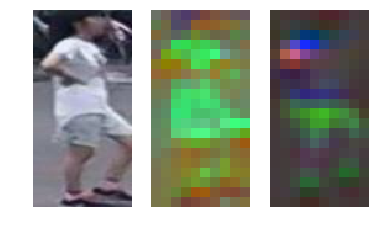

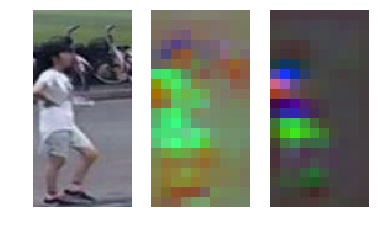

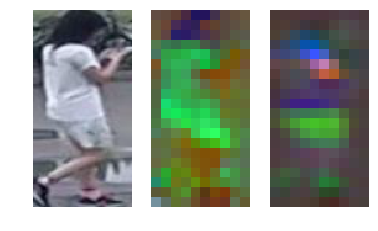

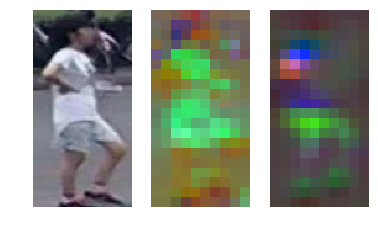

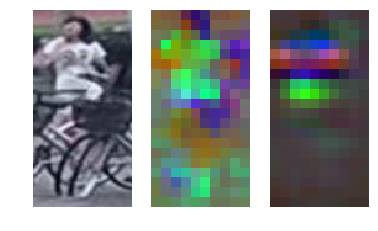

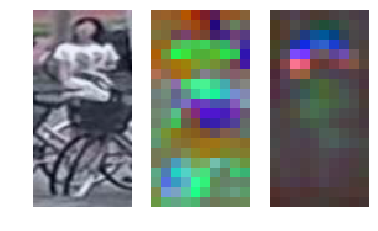

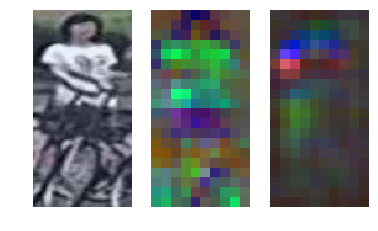

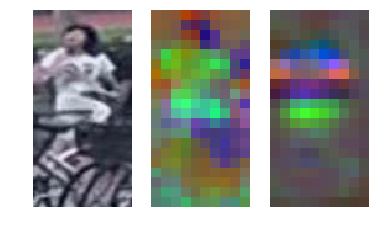

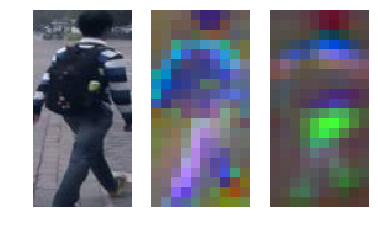

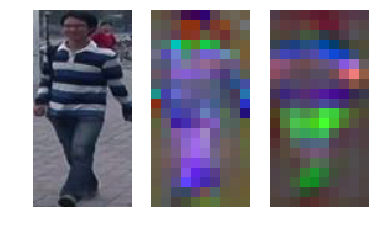

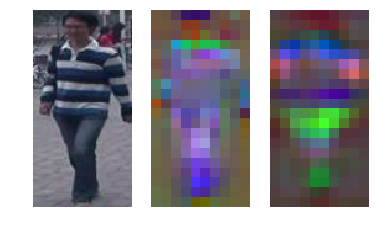

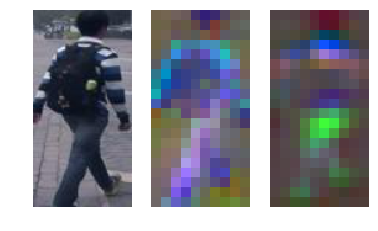

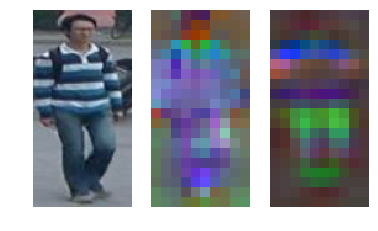

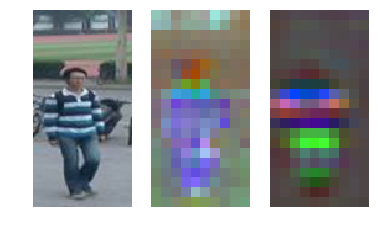

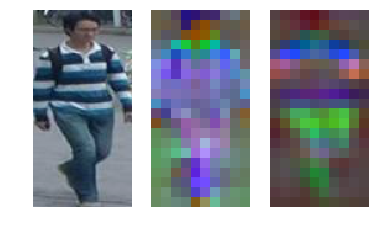

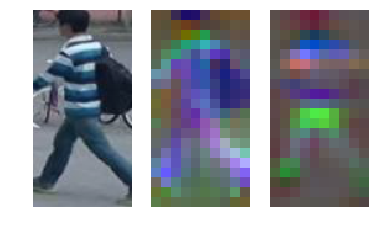

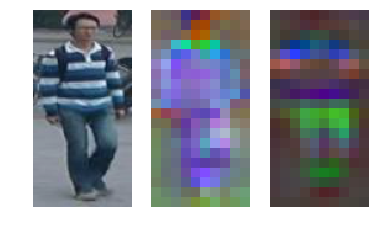

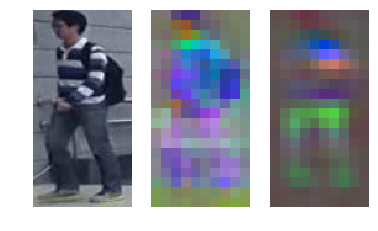

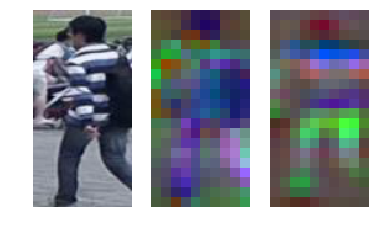

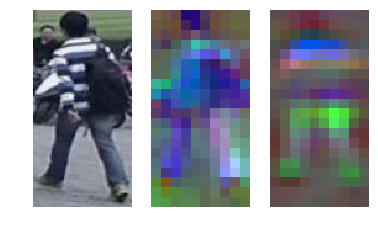

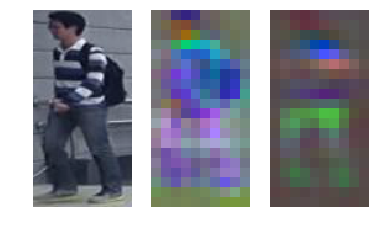

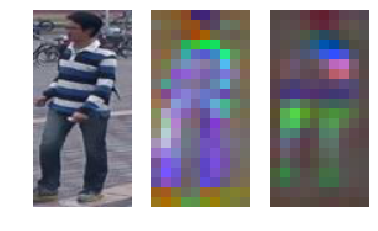

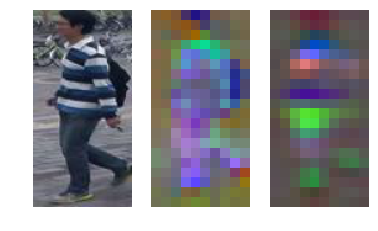

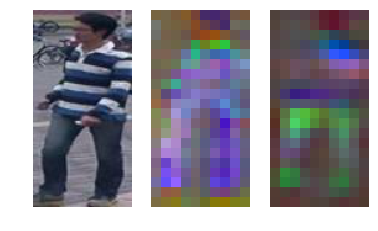

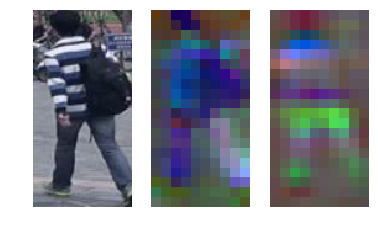

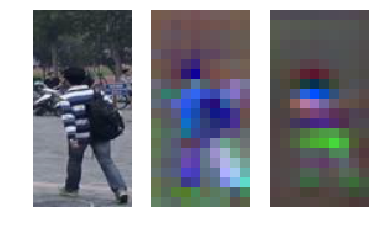

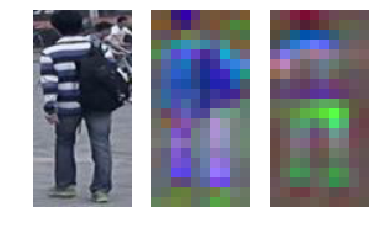

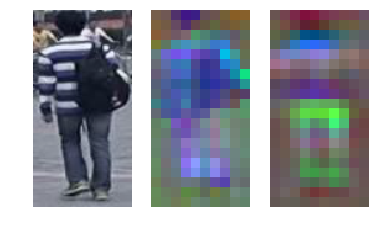

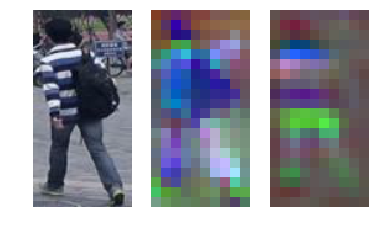

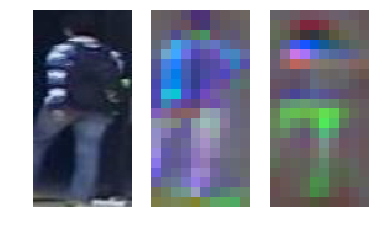

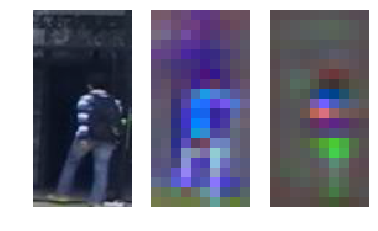

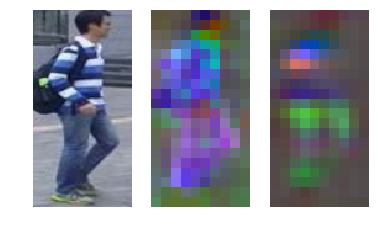

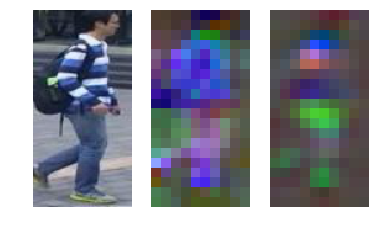

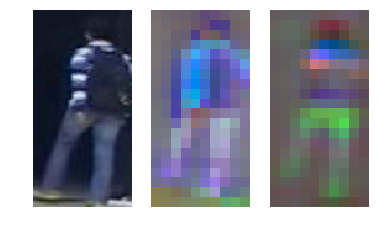

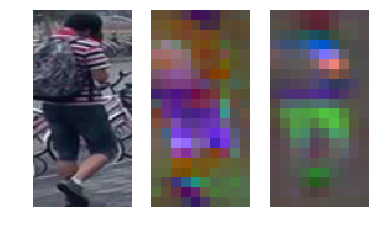

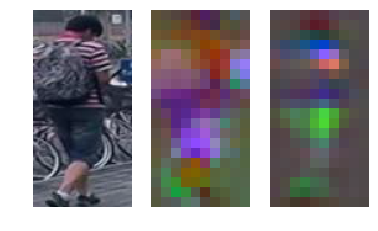

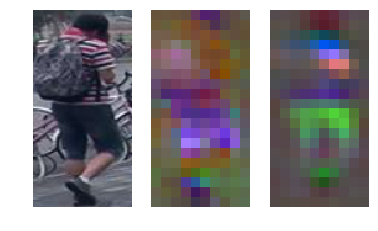

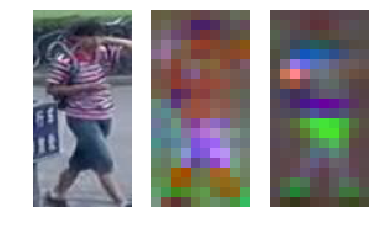

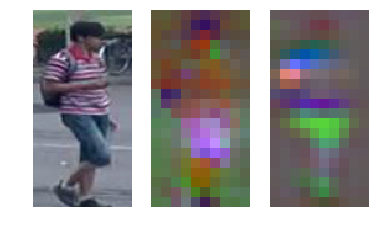

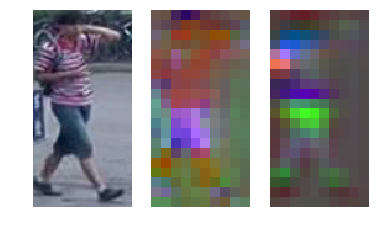

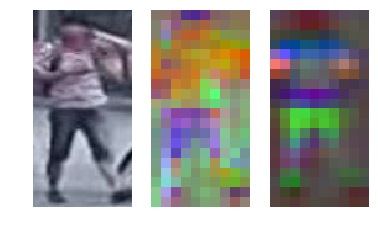

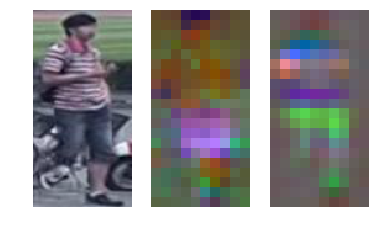

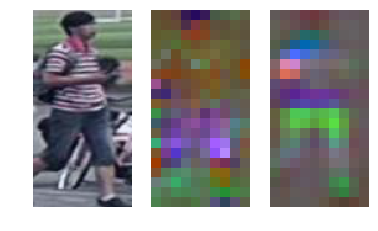

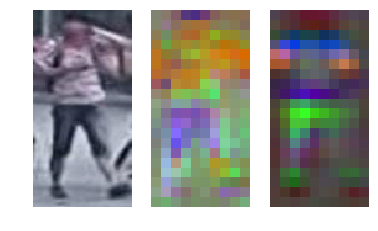

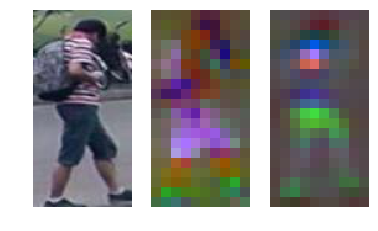

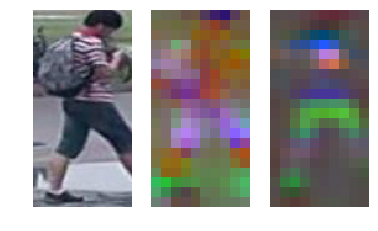

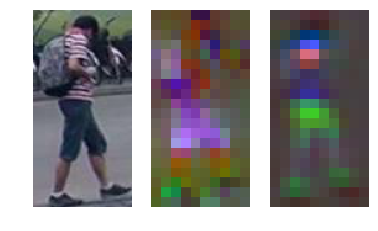

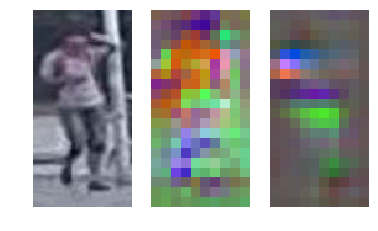

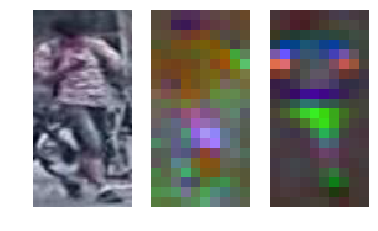

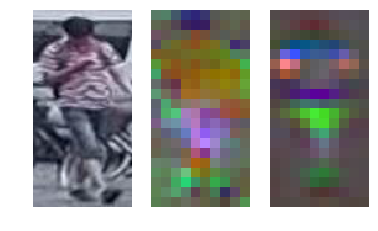

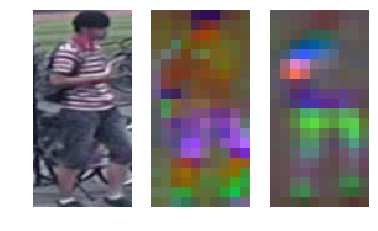

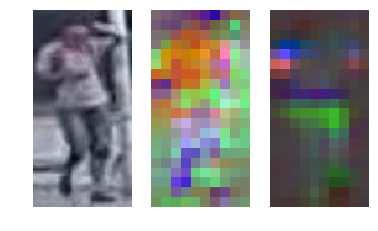

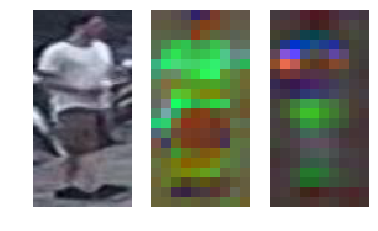

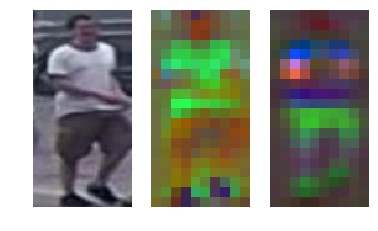

In [3]:
""" Settings """
exp_dir = "logs/market1501/d2_b250"
batch_size = 60
args = json.load(open(osp.join(exp_dir, "args.json"), "r"))
set_paths('paths')
np.random.seed(0)
# np.random.seed(int(time.time()))
# savepath = 'vis_examples/{}_{}.png'

""" Load dataset """
dataset = datasets.create(args['dataset'], "data/{}".format(args['dataset']))
test_transformer = T.Compose([
        T.RectScale(args['height'], args['width']),
        T.CenterCrop((args['crop_height'], args['crop_width'])),
        T.ToTensor(),
        T.RGB_to_BGR(),
        T.NormalizeBy(255),
        ])
target = sel_random_target(list(set(dataset.query) | set(dataset.gallery)))
test_loader = DataLoader(
        Preprocessor(target,
                     root=dataset.images_dir, transform=test_transformer),
        batch_size=batch_size, num_workers=args['workers'],
        shuffle=False, pin_memory=True)

""" Load model """
model = models.create(args['arch'], features=args['features'], 
                      dilation=args['dilation'], initialize=False).cuda()
model_weight = osp.join(exp_dir, 'epoch_750.pth.tar')
checkpoint = load_checkpoint(model_weight)
model.app_feat_extractor.load_state_dict(checkpoint['app_state_dict'])
model.part_feat_extractor.load_state_dict(checkpoint['part_state_dict'])
model.eval()

""" Extract feature maps """
num_test = len(target)
feat1, feat2, feat_out, h, w = 512, 128, 512, 20, 10
pool = CompactBilinearPooling(feat1, feat2, feat_out, sum_pool=True)

app_feats = np.zeros((num_test, feat1, h, w))
part_feats = np.zeros((num_test, feat2, h, w))
bilinear_feats = np.zeros((num_test, feat_out))
target_imgs = np.zeros((num_test, 3, args['crop_height'], args['crop_width']))
for i, (imgs, fnames, pids, _) in enumerate(test_loader):
    app_feat = model.app_feat_extractor(imgs.cuda())
    part_feat = model.part_feat_extractor(imgs.cuda())
    bilinear_feat = pool(app_feat, part_feat)
    
    i_start = i * batch_size
    i_end = min((i+1) * batch_size, num_test)
    app_feats[i_start:i_end, :,:,:] = app_feat.detach().cpu().numpy().copy()
    part_feats[i_start:i_end, :,:,:] = part_feat.detach().cpu().numpy().copy()
    bilinear_feats[i_start:i_end,:] = bilinear_feat.detach().cpu().numpy().copy()
    target_imgs[i_start:i_end, :,:,:] = imgs.detach().cpu().numpy().copy()

""" Visualize maps """
num_vis = 200
visualize_pca_multi([target_imgs[:num_vis], app_feats[:num_vis], part_feats[:num_vis]], bilinear_feats[:num_vis], num_vis=num_vis, save_id="")